## Import the necessary software libraries:

In [1]:
import os
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW
import torch.nn.functional as F
import cv2

from utils import test_policy_network, seed_everything, plot_stats
from parallel_env import ParallelEnv, ParallelWrapper

### import ROM from the extracted file to atari_py

In [ ]:
# for gym 0.20+
# from ale_py import ALEInterface

In [ ]:
# for gym 0.20+
# ale = ALEInterface()

In [ ]:
# for gym 0.20+
# ! ale-import-roms /opt/anaconda3/envs/pongA2C/lib/python3.8/site-packages/ale_py/roms/

In [ ]:
# run only once when creating conda environment
! python -m atari_py.import_roms /Users/meng/Downloads/Roms

In [ ]:
# for gym 0.20+
# from ale_py.roms import Pong

In [ ]:
# for gym 0.20+
# ale.loadROM(Pong)

In [ ]:
# no need to run?
import atari_py

In [ ]:
pip install pyglet==1.5.27

In [3]:
env_name = 'Pong-v4'
#env_name = 'Acrobot-v1'

env = gym.make(env_name)

input_space = env.observation_space.shape

actions = env.action_space.n

In [4]:
print(f"State dimensions: {input_space}. Actions: {actions}")
print(f"Sample state: {env.reset()}")

State dimensions: (210, 160, 3). Actions: 6
Sample state: [[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [109 118  43]
  [109 118  43]
  [109 118  43]]

 [[109 118  43]
  [109 118  43]
  [109 118  43]
  ...
  [109 118  43]
  [109 118  43]
  [109 118  43]]

 [[109 118  43]
  [109 118  43]
  [109 118  43]
  ...
  [109 118  43]
  [109 118  43]
  [109 118  43]]

 ...

 [[ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]
  ...
  [ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]]

 [[ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]
  ...
  [ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]]

 [[ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]
  ...
  [ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]]]


In [5]:
print(f"state_space[0] = {input_space[2]}")

state_space[0] = 3


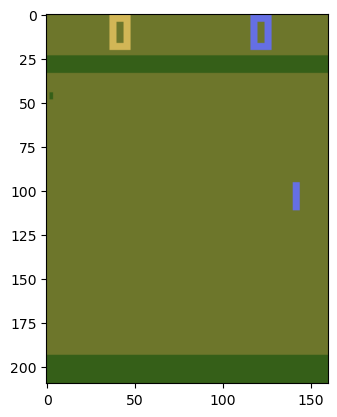

In [6]:
plt.imshow(np.real(env.render(mode='rgb_array')))

In [33]:
class Environment:

    def __init__(self, env_name, obs_shape=(1, 64, 64)):
        self.env = gym.make(env_name)
        self.obs_shape = obs_shape
        seed_everything(self.env)

    def reset(self):
        obs = self.env.reset()
        obs = self.preprocess_observation(obs)
        return obs

    def step_async(self, actions):
        actions = actions.squeeze().numpy()
        self.env.step_async(actions)

    def step_wait(self):
        obs, reward, done, info = self.env.step_wait()
        obs = self.preprocess_observation(obs)
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return obs, reward, done, info

    def preprocess_observation(self, obs):
        # selecting the row from 35 to 195 so that we have a space of 160 * 160
        obs = obs[35:195, :, :]
        # change to gray scale
        #obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        # resize to 
        #obs = cv2.resize(obs, (self.obs_shape[1], self.obs_shape[2]), interpolation=cv2.INTER_AREA)
        #obs = obs.astype(np.float32) / 255.0
        #obs = torch.from_numpy(obs).unsqueeze(0)
        return obs
    
    """
    def render(self, obs):
        # try to show the image after resize but doesn't support
        
        obs = obs[35:195, :, :]
        # change to gray scale
        obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        # resize to 
        obs = cv2.resize(obs, (self.obs_shape[1], self.obs_shape[2]), interpolation=cv2.INTER_AREA)
        obs = obs.astype(np.float32) / 255.0
        
        plt.imshow(np.real(obs.render(mode='rgb_array'))
        
    """

In [8]:
class PreprocessEnv(ParallelWrapper):

    def __init__(self, env):
        super().__init__(env)

    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()

    def step_async(self, actions):
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)

    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [9]:
class FeatureExtractor(nn.Module):

    def __init__(self, input_shape):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*4*4, 512)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 64*4*4)
        
        x = F.relu(self.fc1(x))
        return x
        

In [10]:
class Actor(nn.Module):

    def __init__(self, n_actions):
        super().__init__()

        self.fc1 = nn.Linear(in_features=64*4*4, out_features=512)
        self.fc2 = nn.Linear(in_features=521, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=64)
        self.fc5 = nn.Linear(in_features=64, out_features=n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        x = F.softmax(x, dim=1)
        return x

In [11]:
class Critic(nn.Module):

    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(in_features=64*4*4, out_features=512)
        self.fc2 = nn.Linear(in_features=521, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=64)
        self.fc5 = nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [30]:
class ActorCritic():
    def __init__(self, actor, critic, feature_extractor, alpha=1e-4, gamma=0.99):
        self.actor = actor
        self.critic = critic
        self.feature_extractor = feature_extractor
        self.alpha = alpha
        self.gamma = gamma
        self.actor_optim = AdamW(self.actor.parameters(), lr=1e-3)
        self.critic_optim = AdamW(self.critic.parameters(), lr=1e-4)
        self.stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}

    def train(self, env, episodes):
        state = env.reset()
        
        for episode in tqdm(range(1, episodes + 1)):
            state = env.reset()
            done_b = torch.zeros((env.num_envs, 1), dtype=torch.bool)
            ep_return = torch.zeros((env.num_envs, 1))
            I = 1.

            while not done_b.all():
                
                feature = feature_extractor(state)
                probs = self.actor(feature)
                #probs = self.actor(state)
                
                #action = self.actor(state).multinomial(1).detach()
                action = torch.multinomial(probs, 1).squeeze().detach()
                

                next_state, reward, done, _ = env.step(action)
                
                value = self.critic(feature)
                #value = self.critic(state)
                
                feature_next_state = feature(next_state)
                
                target = reward + ~done * self.gamma * self.critic(feature_next_state).detach() #
                critic_loss = nn.functional.mse_loss(value, target)
                self.critic_optim.zero_grad()
                critic_loss.backward()
                self.critic_optim.step()


                advantage = (target - value).detach()
                #probs = self.actor(state)
                log_probs = torch.log(probs + 1e-6)
                
                action = action.view(-1, 1)
                action_log_prob = log_probs.gather(1, action)
                
                
                action_log_prob = log_probs.gather(1, action)
                entropy = - torch.sum(probs * log_probs, dim=-1, keepdim=True)
                actor_loss = - I * action_log_prob * advantage - 0.01 * entropy
                actor_loss = actor_loss.mean()
                self.actor_optim.zero_grad()
                actor_loss.backward()
                self.actor_optim.step()

                ep_return += reward
                done_b |= done
                state = next_state
                I = I * self.gamma

            self.stats['Actor Loss'].append(actor_loss.item())
            self.stats['Critic Loss'].append(critic_loss.item())
            self.stats['Returns'].append(ep_return.mean().item())

## Main

In [13]:
env_name = 'Pong-v4'
num_envs = os.cpu_count()
episodes = 100

In [31]:
envs = ParallelEnv([lambda: Environment(env_name).reset() for _ in range(num_envs)])
envs = PreprocessEnv(envs)

AttributeError: 'numpy.ndarray' object has no attribute 'observation_space'

In [15]:
feature_extractor = FeatureExtractor(envs.observation_space.shape)
actor = Actor(envs.action_space.n)
critic = Critic()
agent = ActorCritic(actor, critic, feature_extractor)

In [24]:
agent.train(envs, episodes)

  0%|                                                                                                     | 0/100 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [8, 1, 3, 3], expected input[8, 210, 160, 3] to have 1 channels, but got 210 channels instead

In [ ]:
plot_stats(agent.stats)

In [ ]:
test_policy_network(env, agent.actor, episodes=2)

## for testing

In [42]:
env = gym.make(env_name)
print(env.reset())

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [109 118  43]
  [109 118  43]
  [109 118  43]]

 [[109 118  43]
  [109 118  43]
  [109 118  43]
  ...
  [109 118  43]
  [109 118  43]
  [109 118  43]]

 [[109 118  43]
  [109 118  43]
  [109 118  43]
  ...
  [109 118  43]
  [109 118  43]
  [109 118  43]]

 ...

 [[ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]
  ...
  [ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]]

 [[ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]
  ...
  [ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]]

 [[ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]
  ...
  [ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]]]


In [41]:
env = Environment(env_name)
obs = env.reset()
print(env)

In [27]:
obs = envs.reset()
print(obs.shape)

torch.Size([8, 210, 160, 3])


In [ ]:
obs = env.reset()
envs = ParallelEnv([lambda: Environment(env_name).env for _ in range(num_envs)])
print(obs.shape)

## Just in case

In [ ]:

    #def plot_stats(self):
    #    plt.plot(self.stats['Actor Loss'], label='Actor Loss')
    #    plt.plot(self.stats['Critic Loss'], label='Critic Loss')
    #    plt.plot(self.stats['Returns'], label='Returns')
    #    plt.legend()
    #    plt.show()

    #def test_policy_network(self, env, episodes=2):
    #    with torch.no_grad():
    #        for episode in range(episodes):
    #            state = env.reset()
    #            done = False
    #            total_reward = 0

    #            while not done:
    #                action = self.actor(state).argmax(dim=1).detach()
    #                next_state, reward, done, _ = env.step(action)
    #                total_reward += reward
    #                state = next_state

    #            print(f'Episode {episode+1}: Total reward = {total_reward.item()}')
